# LOICA Consortia demonstration

In [1]:
pip install -e .

Note: you may need to restart the kernel to use updated packages.


ERROR: File "setup.py" or "setup.cfg" not found. Directory cannot be installed in editable mode: c:\Users\User\OneDrive\Desktop\Masters PJ\GitHub\LOICA\notebooks


In [2]:
import loica as lc
import matplotlib.pyplot as plt
import networkx as nx
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

This notebook shows the novel functionality that has been encoded in git branch Consortia

This LOICA update allows to create strains that belong to class Strain, taking genetic network and metabolism as parameters.

## Test producer strain
First, set up metabolism and genetic network as usual

In [3]:
def growth_rate(t):
    return 1 # gompertz_growth_rate(t, 0.01, 1, 1, 0.5)

def biomass(t):
    return 1 # gompertz(t, 0.01, 1, 1, 0.5)

metab1 = lc.SimulatedMetabolism("Simulated metabolism 1", biomass, growth_rate)
genetic_n1 = lc.GeneticNetwork()

Then define strain

In [4]:
test_strain = lc.Strain('Test strain', genetic_n1, metab1)
# test
print(test_strain.name)

Test strain


Now, create genetic network as usual. 

### No diffusion

Each gene product now has parameter diffusion_rate, which by default is set to 0. 

LOICA Consortia assumes that:
- all molecules are distrubed equally both incracellularly and extracellularly, so the only diffusion gradient exists between extracellular space and inside of the cell. 
- all cells belonging to the same strain are of uniform size. 

Based on that, diffusion rate here is the proportion of concentration/molecule difference that gets transferred either in- or outside of the cell per change of time. This parameter depend on the average surface area of the cell in the strain.

In [5]:
# Create and add reporter to genetic network
reporter = lc.Reporter(name='GFP', color='green', degradation_rate=0, init_concentration=0)
genetic_n1.add_reporter(reporter)

# Constitutive exression of reporter from strain
source = lc.Source(output=reporter, rate=1000)
genetic_n1.add_operator(source)

Now we have a strain that constitutively expresses GFP. 

Since we have not set diffusion rate, if we create sample, assay and run the latter then check the reporter extracellular concentration, it will stay 0:

In [6]:
sample = lc.Sample(strain=test_strain)
assay = lc.Assay([sample], 
                n_measurements=100, 
                interval=0.24,
                name='GFP constittive expression',
                description='Simulated GFP expression in test strain'
                )

Setting parameter track_all to true will record both intracellular and extracellular concentrations of all GeneProducts in the systems, as well as biomass without accounting for noise and background.

In [7]:
assay.run(stochastic=False, track_all=True)

100%|██████████| 100.0/100 [00:28<00:00,  3.56it/s]


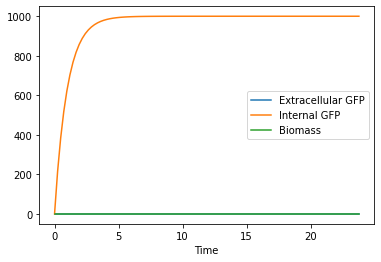

In [8]:
m = assay.measurements
fig,ax = plt.subplots(1,1)
m[m.Signal=='Extracellular GFP'].plot(x='Time', y='Measurement', style='-', ax=ax)
m[m.Signal=='GFP in Test strain'].plot(x='Time', y='Measurement', style='-', ax=ax)
m[m.Signal=='Test strain biomass'].plot(x='Time', y='Measurement', style='-', ax=ax)
plt.legend(['Extracellular GFP', 'Internal GFP', 'Biomass'])

### With diffusion

Now let's add diffusible signal C14 with diffusion rate 1 (all difference gets trasferred)that would also be continiously expressed.

In [9]:
regulator = lc.Regulator(name='C14', degradation_rate=0, init_concentration=0, diffusion_rate=1)
genetic_n1.add_regulator(regulator)

source_2 = lc.Source(output=regulator, rate=1000)
genetic_n1.add_operator(source_2)

In [10]:
sample = lc.Sample(strain=test_strain)
assay2 = lc.Assay([sample], 
                n_measurements=100, 
                interval=0.24,
                name='GFP and C14 constittive expression',
                description='Simulated GFP and C14 expression in test strain'
                )

In [11]:
assay2.run(stochastic=False, track_all=True)

100%|██████████| 100.0/100 [00:38<00:00,  2.58it/s]


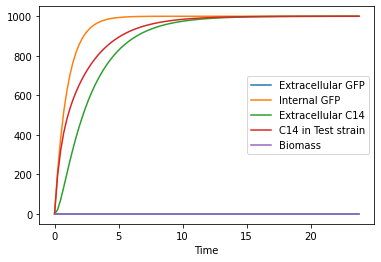

In [12]:
m = assay2.measurements
fig,ax = plt.subplots(1,1)
m[m.Signal=='Extracellular GFP'].plot(x='Time', y='Measurement', style='-', ax=ax)
m[m.Signal=='GFP in Test strain'].plot(x='Time', y='Measurement', style='-', ax=ax)
m[m.Signal=='Extracellular C14'].plot(x='Time', y='Measurement', style='-', ax=ax)
m[m.Signal=='C14 in Test strain'].plot(x='Time', y='Measurement', style='-', ax=ax)
m[m.Signal=='Test strain biomass'].plot(x='Time', y='Measurement', style='-', ax=ax)
plt.legend(['Extracellular GFP', 'Internal GFP', 'Extracellular C14', 'C14 in Test strain', 'Biomass'])

### Extracellular degradation

It is also possible to set extracellular degradation rate for any GeneProduct.

In [14]:
sample.set_extracel_degr("C14", 0.5)
assay3 = lc.Assay([sample], 
                n_measurements=100, 
                interval=0.24,
                name='GFP and C14 constittive expression with C14 extracellular degradation',
                description='Simulated GFP and C14 expression in test strain'
                )

In [15]:
assay3.run(stochastic=False, track_all=True)

100%|██████████| 100.0/100 [00:41<00:00,  2.41it/s]


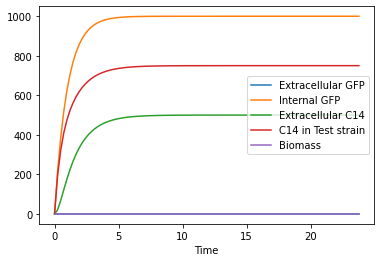

In [16]:
m = assay3.measurements
fig,ax = plt.subplots(1,1)
m[m.Signal=='Extracellular GFP'].plot(x='Time', y='Measurement', style='-', ax=ax)
m[m.Signal=='GFP in Test strain'].plot(x='Time', y='Measurement', style='-', ax=ax)
m[m.Signal=='Extracellular C14'].plot(x='Time', y='Measurement', style='-', ax=ax)
m[m.Signal=='C14 in Test strain'].plot(x='Time', y='Measurement', style='-', ax=ax)
m[m.Signal=='Test strain biomass'].plot(x='Time', y='Measurement', style='-', ax=ax)
plt.legend(['Extracellular GFP', 'Internal GFP', 'Extracellular C14', 'C14 in Test strain', 'Biomass'])

## Sender-Receiver consortium

### Sender strain

In [18]:
def growth_rate_sender(t):
    return 2 # gompertz_growth_rate(t, 0.01, 1, 1, 0.5)

def biomass_sender(t):
    return 2 # gompertz(t, 0.01, 1, 1, 0.5)

metab_sender = lc.SimulatedMetabolism("Simulated metabolism receiver", biomass_sender, growth_rate_sender)
genetic_network_sender = lc.GeneticNetwork()
sender = lc.Strain('Sender', genetic_network_sender, metab_sender)
# test
print(sender.name)

Sender


In [19]:
# Create and add reporter to genetic network
signal = lc.Regulator(name='C14', degradation_rate=0, init_concentration=0, diffusion_rate=0.5)
genetic_network_sender.add_regulator(signal)

# Constitutive exression of signal in sender
signal_source = lc.Source(output=signal, rate=1000)
genetic_network_sender.add_operator(signal_source)

### Receiver strain

In [ ]:
def growth_rate_receiver(t):
    return 1 # gompertz_growth_rate(t, 0.01, 1, 1, 0.5)

def biomass_receiver(t):
    return 1 # gompertz(t, 0.01, 1, 1, 0.5)

metab_receiver = lc.SimulatedMetabolism("Simulated metabolism receiver", biomass_receiver, growth_rate_receiver)
genetic_network_receiver = lc.GeneticNetwork()
receiver = lc.Strain('Receiver', genetic_network_receiver, metab_receiver)
# test
print(receiver.name)

Sender


When defining multiple strains, if molecule can diffuse to cell ("receiver") that doesn't belong to the producer strain, it has to be defined within the "receiver" strain as well. Since instance of GeneProduct has own internal concentration, assigning the same value for different genetic networks will not work, as different strains with different degetic networks will have different dynamics. 

In [ ]:
# Create and add regulator to genetic network
signal_in_r = lc.Regulator(name='C14', degradation_rate=0, init_concentration=0, diffusion_rate=0.5)
genetic_network_receiver.add_regulator(signal_in_r)

# Create and add reporter
gfp = lc.Reporter(name='GFP', degradation_rate=0, init_concentration=0)
genetic_network_receiver.add_reporter(gfp)

# Exression of GFP activated by C14
c14_to_gfp = lc.Hill1(name='Pcin', input=signal_in_r, output=gfp, alpha=[0, 100], K=10, n=2)
genetic_network_receiver.add_operator(c14_to_gfp)